# Create all image csv files

In [268]:
import os
import csv

def create_csv(image_folder, csv_file_path):
    # Define the CSV header fields
    fieldnames = ['HospitalID', 'PatientID', 'ImageID', 'ImagePath', 'Label']
    
    # Open the CSV file in write mode
    with open(csv_file_path, 'w', newline='') as csvfile:
        # Create a CSV writer object and write the header
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()

        # Iterate through files in the folder
        for filename in sorted(os.listdir(image_folder)):
            # Construct the complete image file path
            image_path = os.path.join(image_folder, filename)

            # Parse the filename to extract HospitalID, PatientID, image number, and image label
            parts = filename.split('_')
            hospital_id = parts[3]
            patient_id = parts[1]
            image_number = parts[6]
            image_label = parts[4]

            # Write data into the CSV file
            writer.writerow({
                'HospitalID': hospital_id,
                'PatientID': patient_id,
                'ImageID': image_number,
                'ImagePath': image_path,
                'Label': image_label
            })

    # Print a message indicating that the CSV file has been created and saved
    print("CSV file has been created and saved to:", csv_file_path)


image_folder = "/local/data1/honzh073/data/8bit_downsample_256"
csv_file_path = "/local/data1/honzh073/local_repo/FL/code/3_single_hospital/csv_files/image_data.csv"
create_csv(image_folder, csv_file_path)


CSV file has been created and saved to: /local/data1/honzh073/local_repo/FL/code/3_single_hospital/csv_files/image_data.csv


# copy images from csv file path

In [269]:
# import pandas as pd

# input_csv_path = "/local/data1/honzh073/local_repo/FL/code/3_single_hospital/csv_files/image_data.csv"

# # 读取CSV文件
# data = pd.read_csv(input_csv_path)

# # 找出医院ID为43的所有图片路径
# hospital_43_images = data[data['HospitalID'] == 43]['ImagePath']

# import shutil
# import os

# # 指定目标文件夹路径
# target_folder = "/local/data1/honzh073/data/hospital_43_processed"

# # 遍历医院ID为43的所有图片路径，将它们复制到指定文件夹
# for image_path in hospital_43_images:
#     # 获取图片文件名
#     image_filename = os.path.basename(image_path)
    
#     # 构造目标文件路径
#     target_path = os.path.join(target_folder, image_filename)
    
#     # 复制图片文件
#     shutil.copy(image_path, target_path)

# print("Images copied successfully.")


# Split by patient ID on single hospital

In [270]:
import csv
from collections import defaultdict
import random

def split_and_save_data(input_csv_path, output_folder, target_hospital_ids, train_ratio, val_ratio, seed):
    patient_data = defaultdict(list)
    
    with open(input_csv_path, 'r') as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            if row['HospitalID'] in target_hospital_ids:
                patient_id = row['PatientID']
                patient_data[patient_id].append(row)

    num_patients = len(patient_data)

    num_train = int(num_patients * train_ratio)
    num_val = int(num_patients * val_ratio)
    # num_test = num_patients - num_train - num_val

    # get random IDs
    all_patient_ids = list(patient_data.keys())

    random.seed(seed)
    random.shuffle(all_patient_ids)

    # split by ID
    train_patients = all_patient_ids[ : num_train]
    val_patients = all_patient_ids[num_train : num_train + num_val]
    test_patients = all_patient_ids[num_train + num_val : ]

    # iter by patient IDs
    train_data = []
    val_data = []
    test_data = []

    for patient_id, images in patient_data.items():
        if patient_id in train_patients:
            train_data.extend(images)
        elif patient_id in val_patients:
            val_data.extend(images)
        elif patient_id in test_patients:
            test_data.extend(images)

    # write to csv
    def write_to_csv(file_path, data):
        with open(file_path, 'w', newline='') as csvfile:
            writer = csv.DictWriter(csvfile, fieldnames=data[0].keys())
            writer.writeheader()
            writer.writerows(data)

    # Write to CSV files
    write_to_csv(os.path.join(output_folder, 'train.csv'), train_data)
    write_to_csv(os.path.join(output_folder, 'val.csv'), val_data)
    write_to_csv(os.path.join(output_folder, 'test.csv'), test_data)
    
    print("Saved train.csv, val.csv, and test.csv.")

# input and output path
input_csv_path = "/local/data1/honzh073/local_repo/FL/code/3_single_hospital/csv_files/image_data.csv"
output_folder = '/local/data1/honzh073/local_repo/FL/code/3_single_hospital/csv_files/'

# single hospital id
target_hospital_ids = ['43']

# random seed
seed = 1

# train and val dataset ratio
train_ratio = 0.4
val_ratio = 0.3
# test_ratio = 0.3 # unnecessary

split_and_save_data(input_csv_path, output_folder,
                    train_ratio=train_ratio, val_ratio=val_ratio, 
                    target_hospital_ids = target_hospital_ids,
                    seed = seed)


Saved train.csv, val.csv, and test.csv.


In [271]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import models
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, roc_auc_score

# get training class weight, aff : nff = 2:8
def get_classweight(train_dataset):
    train_nff_count = sum(1 for _, label in train_dataset if label == 0)  # 0 NFF
    train_aff_count = sum(1 for _, label in train_dataset if label == 1)  # 1 AFF
    class_weight_nff = 1 / (2 * (train_nff_count / (train_nff_count + train_aff_count)))
    class_weight_aff = 1 / (2 * (train_aff_count / (train_nff_count + train_aff_count)))
    
    return [class_weight_nff, class_weight_aff] # 0 nff , 1 aff 

# training function
def train_model(train_loader, validation_loader, classweight, num_epochs, lr, step_size, gamma, model_name):
    # Load pre-trained model
    torch.hub.set_dir('/local/data1/honzh073/download/TORCH_PRETRAINED')
    
    if model_name == 'resnet18':
        from torchvision.models import resnet18, ResNet18_Weights
        model = models.resnet18(weights=ResNet18_Weights.DEFAULT)
    
    elif model_name == 'resnet50':
        from torchvision.models import resnet50, ResNet50_Weights
        model = models.resnet50(weights=ResNet50_Weights.DEFAULT)
        
    elif model_name == 'resnet101':
        from torchvision.models import resnet101, ResNet101_Weights
        model = models.resnet101(weights=ResNet101_Weights.DEFAULT)
         
    elif model_name == 'resnet152':
        from torchvision.models import resnet152, ResNet152_Weights
        model = models.resnet152(weights=ResNet152_Weights.DEFAULT)
        
    elif model_name == 'densenet161':
        from torchvision.models import densenet161, DenseNet161_Weights
        model = models.densenet161(weights=DenseNet161_Weights.DEFAULT)

    elif model_name == 'vgg19':
        from torchvision.models import vgg19, VGG19_Weights
        model = models.vgg19(weights=VGG19_Weights.DEFAULT)
        
    else:
        raise ValueError("Invalid model type. 'vgg19' 'resnet50' 'resnet101' 'resnet152' or 'densenet161'.")
    
    # freeze all layers except fc
    # for param in model.parameters():
    #     param.requires_grad = False
    
    # fc
    num_class = 2
    
    if model_name == 'densenet161':
        in_features = model.classifier.in_features
        model.classifier = nn.Sequential(nn.Dropout(0.5),nn.Linear(in_features, num_class)) # dropout
        # model.classifier = nn.Sequential(nn.Linear(in_features, num_class)) # no dropout
    if model_name == 'vgg19':
        in_features = model.classifier[0].in_features
        model.classifier = nn.Sequential(nn.Dropout(0.5),nn.Linear(in_features, num_class)) # dropout
        # model.classifier = nn.Sequential(nn.Linear(in_features, num_class)) # no dropout
    # fc1 = vgg_model.classifier[0]

    else:
        in_features = model.fc.in_features
        model.fc = nn.Sequential(nn.Dropout(0.5), nn.Linear(in_features, num_class)) # dropout
        # model.fc = nn.Sequential(nn.Linear(in_features, num_class)) # no dropout
    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    # # DataParallel speed up
    # if torch.cuda.device_count() > 1:
    #     print("multiple GPU:", torch.cuda.device_count())
    #     model = nn.DataParallel(model)
    # else:
    #     print("single GPU")
    #     model = model.to(device)
    
    # loss function and learning rate
    criterion = nn.CrossEntropyLoss(weight=torch.Tensor(classweight).to(device))
    # optimizer = optim.Adam(model.parameters(), lr=lr)
    
    optimizer = optim.RMSprop(model.parameters(), lr=lr)

    scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
        
    # Loss, ACC
    train_losses = []
    validation_losses = []
    train_accuracies = []
    validation_accuracies = []
    
    # select best model
    best_validation_accuracy = 0
    best_model = None

    for epoch in range(num_epochs):
        model.train()
        correct_train = 0
        total_train = 0
        
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
        
        train_accuracy = 100 * correct_train / total_train
        
        model.eval()
        correct_validation_aff = 0
        total_validation_aff = 0
        correct_validation = 0
        total_validation = 0
        validation_loss = 0
        
        with torch.no_grad():
            for images, labels in validation_loader:
                images = images.to(device)
                labels = labels.to(device)
                
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                _, predicted = torch.max(outputs.data, 1)
                total_validation += labels.size(0)
                correct_validation += (predicted == labels).sum().item()
                validation_loss += loss.item()
                # Calculate accuracy for AFF class
                total_validation_aff += torch.sum(labels == 1).item()
                correct_validation_aff += torch.sum((predicted == 1) & (labels == 1)).item()

        validation_accuracy_aff = 100 * correct_validation_aff / total_validation_aff

        # validation accuracy and loss
        validation_accuracy = 100 * correct_validation / total_validation
        validation_loss /= len(validation_loader)
        
        train_losses.append(loss.item())
        validation_losses.append(validation_loss)
        train_accuracies.append(train_accuracy)
        validation_accuracies.append(validation_accuracy)
        
        print(f"Epoch {epoch+1}/{num_epochs}, "
            f"train Loss: {loss.item():.4f}, "
            f"val Loss: {validation_loss:.4f}, "
            f"train ACC: {train_accuracy:.2f}%, "
            f"Val ACC: {validation_accuracy:.2f}%")
        
        scheduler.step()
        
        # select by high aff ACC
        # if validation_accuracy_aff > best_accuracy:
        #     best_accuracy = validation_accuracy_aff
        #     best_model = model.module if isinstance(model, nn.DataParallel) else model

        if validation_accuracy > best_validation_accuracy:
            best_validation_accuracy = validation_accuracy
            # best_model = model.module  # DataParallel
            best_model = model  # single device
            
    # Plot train/val loss,  accuracy
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(validation_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(validation_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend() 

    plt.show()

    return best_model

def test_model(model, test_dataset, batch_size):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)
    model.eval()
    
    correct_test = 0
    total_test = 0
    test_loss = 0
    
    criterion = nn.CrossEntropyLoss()
    
    with torch.no_grad():
        all_predictions = []
        all_labels = []
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            _, predicted = torch.max(outputs.data, 1)
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()
            test_loss += loss.item()

    test_accuracy = 100 * correct_test / total_test
    test_loss /= len(test_loader)

    print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_accuracy:.2f}%")
     
    auc_score = roc_auc_score(all_labels, all_predictions)
    conf_matrix = confusion_matrix(all_labels, all_predictions)
    
    # Precision、Recall、F1 Score
    class_labels = {0: 'NFF', 1: 'AFF'}

    classification_rep = classification_report(all_labels, all_predictions, target_names=[class_labels[i] for i in range(len(class_labels))])
    print("AUC:", auc_score)
    print("Confusion Matrix:")
    print(conf_matrix)
    print("Classification Report:")
    print(classification_rep)

    plot_roc_curve(all_labels, all_predictions)
    
def plot_roc_curve(all_labels, all_predictions):
    fpr, tpr, thresholds = roc_curve(all_labels, all_predictions)
    roc_auc = roc_auc_score(all_labels, all_predictions)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

def show_image(dataset, num_images=5):
    # Get random indices
    random_indices = np.random.choice(len(dataset), num_images, replace=False)

    # Plot images with truncated names
    plt.figure(figsize=(15, 5))
    for i, idx in enumerate(random_indices):
        image, label = dataset[idx]  # Use the dataset directly
        filename = dataset.data[idx][0]  # Get the filename from dataset's internal data attribute
        truncated_filename = filename.split('/')[-1][:15]  # Extract the last part and truncate to 15 characters
        
        # Print the original filename
        print(f"Image location: {filename}")

        plt.subplot(1, num_images, i + 1)
        plt.title(f"Label: {label}")
        plt.imshow(image[0])  # Assuming single-channel (grayscale) image
        # plt.imshow(image[0], cmap='gray')  # Assuming single-channel (grayscale) image

        plt.axis('off')
    plt.show()
    
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)



training class weight [0.8, 1.3333333333333333]
Image location: /local/data1/honzh073/data/8bit_downsample_256/patient_JTCVKHWOJN_hospital_43_AFF_image_3.png
Image location: /local/data1/honzh073/data/8bit_downsample_256/patient_ZTXRVFVGTK_hospital_43_AFF_image_3.png
Image location: /local/data1/honzh073/data/8bit_downsample_256/patient_EIIXGIKSDW_hospital_43_NFF_image_1.png
Image location: /local/data1/honzh073/data/8bit_downsample_256/patient_HVTVEBPSCC_hospital_43_NFF_image_1.png
Image location: /local/data1/honzh073/data/8bit_downsample_256/patient_MMOQGMWSNT_hospital_43_AFF_image_1.png
Image location: /local/data1/honzh073/data/8bit_downsample_256/patient_LIDDUNYZKJ_hospital_43_NFF_image_2.png
Image location: /local/data1/honzh073/data/8bit_downsample_256/patient_KSCCWJHMTJ_hospital_43_AFF_image_4.png
Image location: /local/data1/honzh073/data/8bit_downsample_256/patient_TADAVBRLUJ_hospital_43_NFF_image_3.png
Image location: /local/data1/honzh073/data/8bit_downsample_256/patient_G

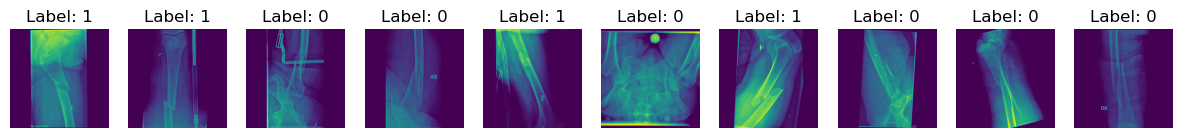

Saved train.csv, val.csv, test.csv.
-----------------------------------
train AFF: 36, ratio: 0.38
----- NFF: 60, ratio: 0.62
-----------------------------------
val AFF: 16, ratio: 0.24
--- NFF: 50, ratio: 0.76
-----------------------------------
test AFF: 23, ratio: 0.28
---- NFF: 60, ratio: 0.72


In [287]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import csv
import pandas as pd

# read image, image by csv. Custom dataset
class CustomDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = []
        self.transform = transform
        # read csv
        with open(csv_file, 'r') as csvfile:
            reader = csv.DictReader(csvfile)
            for row in reader:
                image_path = row['ImagePath']
                label = row['Label']

                if label == 'NFF':
                    label = 0
                elif label == 'AFF':
                    label = 1
                else:
                    raise ValueError("Invalid label in CSV file.")
                self.data.append((image_path, label))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_path, label = self.data[idx]
        # image = Image.open(image_path).convert('L')  # 'L' to gray image
        image = Image.open(image_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label
    def get_class_counts(self):
        return {'AFF': self.AFF_count, 'NFF': self.NFF_count}

# Define data augmentation transforms for training data

train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    # transforms.RandomRotation(20),
    # # transforms.ColorJitter(brightness=0.5, contrast=0.1, saturation=0.1, hue=0.3),
    # # transforms.GaussianBlur(kernel_size=(3,3), sigma=(0.1, 5)),
    transforms.RandomAdjustSharpness(sharpness_factor=5),
    # transforms.RandomAutocontrast(),
    # transforms.CenterCrop(256),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # mean=[0.5], std=[0.5]

])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # mean=[0.5], std=[0.5]


])

train_dataset = CustomDataset('/local/data1/honzh073/local_repo/FL/code/3_single_hospital/csv_files/train.csv', transform=train_transform)
val_dataset = CustomDataset('/local/data1/honzh073/local_repo/FL/code/3_single_hospital/csv_files/val.csv', transform=test_transform)
test_dataset = CustomDataset('/local/data1/honzh073/local_repo/FL/code/3_single_hospital/csv_files/test.csv', transform=test_transform)

repeated_dataset = torch.utils.data.ConcatDataset([train_dataset] * 10)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# classweight
classweight = get_classweight(train_dataset)
print('training class weight', classweight)

# device
# device = torch.device("cuda:0" if  torch.cuda.is_available() else "cpu")

show_image(train_dataset, 10)

print("Saved train.csv, val.csv, test.csv.")
print('-----------------------------------')
train_NFF_count = sum(1 for _, label in train_dataset if label == 0)  # 0 NFF
train_AFF_count = sum(1 for _, label in train_dataset if label == 1)  # 1 AFF

# For validation dataset
val_NFF_count = sum(1 for _, label in val_dataset if label == 0)  # 0 NFF
val_AFF_count = sum(1 for _, label in val_dataset if label == 1)  # 1 AFF

# For test dataset
test_NFF_count = sum(1 for _, label in test_dataset if label == 0)  # 0 NFF
test_AFF_count = sum(1 for _, label in test_dataset if label == 1)  # 1 AFF


print(f"train AFF: {train_AFF_count}, ratio: {train_AFF_count / (train_AFF_count + train_NFF_count):.2f}")
print(f"----- NFF: {train_NFF_count}, ratio: {train_NFF_count / (train_AFF_count + train_NFF_count):.2f}")
print('-----------------------------------')
print(f"val AFF: {val_AFF_count}, ratio: {val_AFF_count / (val_AFF_count + val_NFF_count):.2f}")
print(f"--- NFF: {val_NFF_count}, ratio: {val_NFF_count / (val_AFF_count + val_NFF_count):.2f}")
print('-----------------------------------')
print(f"test AFF: {test_AFF_count}, ratio: {test_AFF_count / (test_AFF_count + test_NFF_count):.2f}")
print(f"---- NFF: {test_NFF_count}, ratio: {test_NFF_count / (test_AFF_count + test_NFF_count):.2f}")



In [277]:
epoch_num = 50
step_size = 10
lr = 1e-4

Epoch 1/50, train Loss: 0.2769, val Loss: 0.4504, train ACC: 55.21%, Val ACC: 75.76%
Epoch 2/50, train Loss: 0.3793, val Loss: 0.4668, train ACC: 60.42%, Val ACC: 87.88%
Epoch 3/50, train Loss: 0.4220, val Loss: 0.5069, train ACC: 80.21%, Val ACC: 69.70%
Epoch 4/50, train Loss: 1.4752, val Loss: 1.3418, train ACC: 90.62%, Val ACC: 50.00%
Epoch 5/50, train Loss: 0.2401, val Loss: 0.3933, train ACC: 92.71%, Val ACC: 83.33%
Epoch 6/50, train Loss: 0.1016, val Loss: 0.2952, train ACC: 97.92%, Val ACC: 83.33%
Epoch 7/50, train Loss: 0.1383, val Loss: 0.5590, train ACC: 98.96%, Val ACC: 75.76%
Epoch 8/50, train Loss: 0.0104, val Loss: 0.3851, train ACC: 97.92%, Val ACC: 80.30%
Epoch 9/50, train Loss: 0.0047, val Loss: 0.3974, train ACC: 100.00%, Val ACC: 83.33%
Epoch 10/50, train Loss: 0.0193, val Loss: 0.3448, train ACC: 98.96%, Val ACC: 81.82%
Epoch 11/50, train Loss: 0.0282, val Loss: 0.3466, train ACC: 98.96%, Val ACC: 83.33%
Epoch 12/50, train Loss: 0.0381, val Loss: 0.3491, train ACC: 

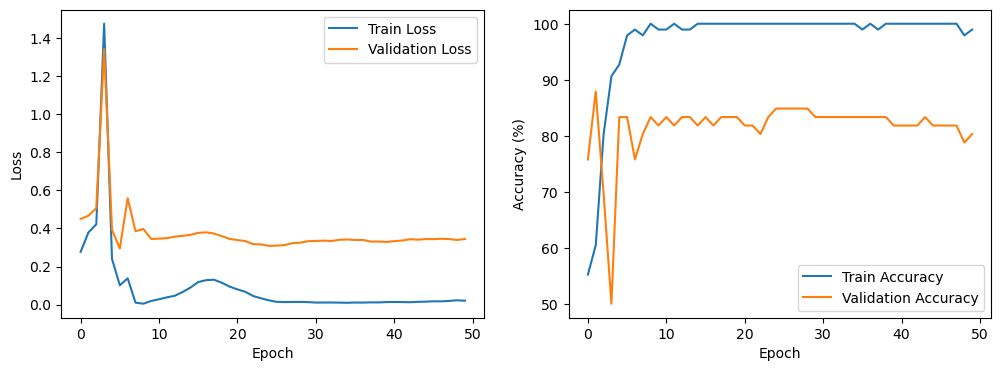

In [288]:
# resnet101
resnet101 = train_model(train_loader, val_loader, classweight, 
                        num_epochs=epoch_num, lr=lr, step_size=step_size, gamma=0.1, model_name='resnet101')


ResNet 101
Test Loss: 0.2832, Test Acc: 81.93%
AUC: 0.7543478260869566
Confusion Matrix:
[[54  6]
 [ 9 14]]
Classification Report:
              precision    recall  f1-score   support

         NFF       0.86      0.90      0.88        60
         AFF       0.70      0.61      0.65        23

    accuracy                           0.82        83
   macro avg       0.78      0.75      0.76        83
weighted avg       0.81      0.82      0.82        83



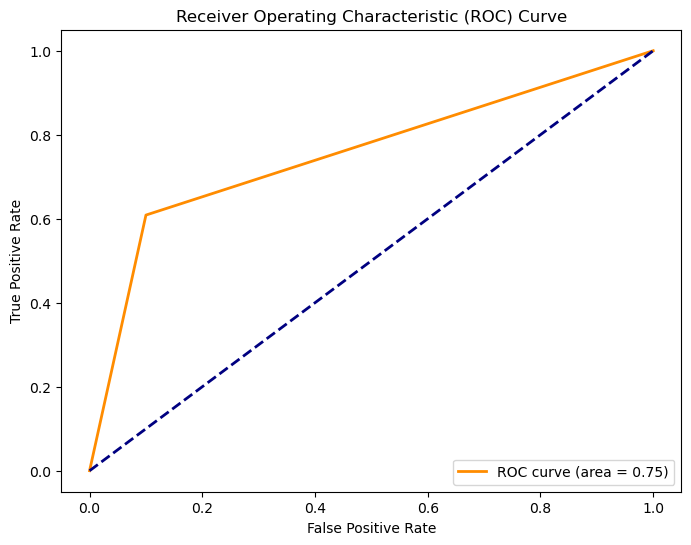

number of parameters: 42504258


In [289]:
print('ResNet 101')
test_model(model=resnet101, test_dataset=test_dataset, batch_size=batch_size)
params_count = count_parameters(resnet101)
print(f"number of parameters: {params_count}")


Epoch 1/50, train Loss: 0.8330, val Loss: 0.7879, train ACC: 58.33%, Val ACC: 31.82%
Epoch 2/50, train Loss: 0.6700, val Loss: 0.6625, train ACC: 70.83%, Val ACC: 53.03%
Epoch 3/50, train Loss: 0.5356, val Loss: 0.5527, train ACC: 80.21%, Val ACC: 62.12%
Epoch 4/50, train Loss: 0.1606, val Loss: 0.3400, train ACC: 88.54%, Val ACC: 80.30%
Epoch 5/50, train Loss: 0.3864, val Loss: 0.7913, train ACC: 92.71%, Val ACC: 59.09%
Epoch 6/50, train Loss: 0.0318, val Loss: 0.4255, train ACC: 93.75%, Val ACC: 83.33%
Epoch 7/50, train Loss: 0.0570, val Loss: 0.4112, train ACC: 95.83%, Val ACC: 78.79%
Epoch 8/50, train Loss: 0.0350, val Loss: 0.4051, train ACC: 97.92%, Val ACC: 84.85%
Epoch 9/50, train Loss: 0.0171, val Loss: 0.3686, train ACC: 100.00%, Val ACC: 81.82%
Epoch 10/50, train Loss: 0.0764, val Loss: 0.5280, train ACC: 98.96%, Val ACC: 77.27%
Epoch 11/50, train Loss: 0.0964, val Loss: 0.5097, train ACC: 96.88%, Val ACC: 77.27%
Epoch 12/50, train Loss: 0.0941, val Loss: 0.4631, train ACC: 

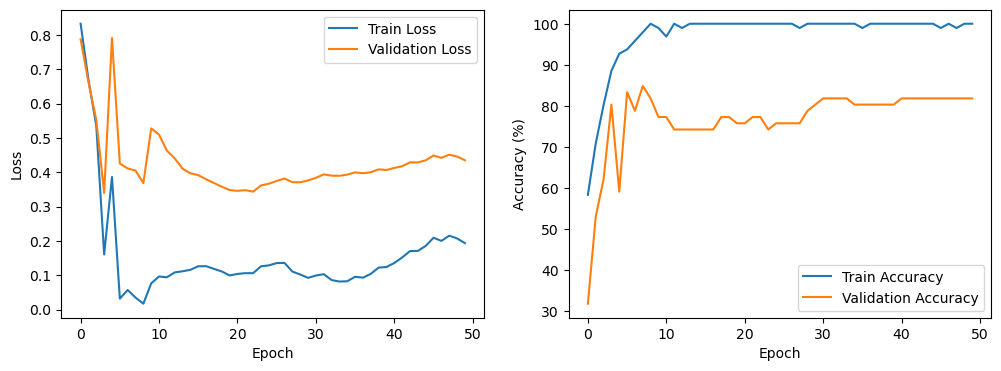

In [290]:
# resnet152
resnet152 = train_model(train_loader, val_loader, classweight, 
                        num_epochs=epoch_num, lr=lr, step_size=step_size, gamma=0.1, model_name='resnet152')


ResNet 152
Test Loss: 0.3391, Test Acc: 83.13%
AUC: 0.8163043478260869
Confusion Matrix:
[[51  9]
 [ 5 18]]
Classification Report:
              precision    recall  f1-score   support

         NFF       0.91      0.85      0.88        60
         AFF       0.67      0.78      0.72        23

    accuracy                           0.83        83
   macro avg       0.79      0.82      0.80        83
weighted avg       0.84      0.83      0.84        83



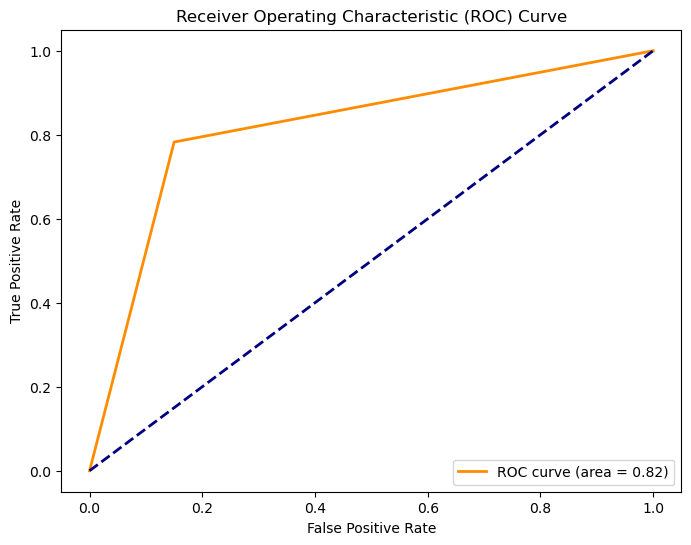

number of parameters: 58147906


In [291]:
print('ResNet 152')
test_model(model=resnet152, test_dataset=test_dataset, batch_size=batch_size)
params_count = count_parameters(resnet152)
print(f"number of parameters: {params_count}")


In [ ]:
# densenet161

# densenet161 = train_model(train_loader, val_loader, classweight, 
#                           num_epochs=epoch_num, lr=lr, step_size=step_size, gamma=0.1, model_name='densenet161')


AttributeError: 'DenseNet' object has no attribute 'fc'

In [ ]:
# test_model(model=densenet161, test_dataset=test_dataset, batch_size=batch_size)

In [ ]:
# # vgg19
# vgg19 = train_model(train_loader, val_loader, classweight, 
#                           num_epochs=epoch_num, lr=lr, step_size=step_size, gamma=0.1, model_name='vgg19')


In [ ]:
# test_model(model=vgg19, test_dataset=test_dataset, batch_size=batch_size)